## This is a simple extension of the facial recognition project, processed in 2023
I tried to apply the Residual Neural Network (ResNet) onthe same dataset, and made comparison of the result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=30,resize=0.4)

In [4]:
batch_size = 128
n_epochs = 30

scaler = preprocessing.MinMaxScaler()

X=torch.tensor(scaler.fit_transform(people['data']))
y=torch.tensor(people['target'])

n_samples, h, w =people['images'].shape
#Train : Test = 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train = X_train.reshape((-1,1, h, w))
X_test = X_test.reshape((-1,1, h, w))

train_dataset = [(X_train[i],y_train[i]) for i in range(X_train.shape[0])]
test_dataset = [(X_test[i],y_test[i]) for i in range(X_test.shape[0])]
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Number of Class
n_classes = len(np.unique(y_train))

In [5]:
class Resnet18(nn.Module):
    def __init__(self, in_channels=1, n_outputs=n_classes):
        super(Resnet18, self).__init__()
        self.model = torchvision.models.resnet18(weights=True)
        #First layer
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Last layer
        self.model.fc = nn.Linear(self.model.fc.in_features, n_outputs)

    def forward(self, x):
        return self.model(x)

In [6]:
model = Resnet18().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001,eps=0.0001)

/Users/kikuamano/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(n_epochs):
    print(f"Processing epoch {epoch+1}/{n_epochs}")
    total_loss=0
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
     
    with torch.no_grad():
        model.eval()
        
        
        n_correct = 0
        n_samples = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        train_loss.append(total_loss/i)
        train_acc.append(n_correct/n_samples) 
        
        total_loss = 0
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss+=loss.item()
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
    val_loss.append(total_loss/i)
    val_acc.append(n_correct/n_samples) 
    
    print(f"train loss = {np.round(train_loss[-1],4)}, validation accuracy = {np.round(val_acc[-1],4)}")
    

Processing epoch 1/30
train loss = 2.9129, validation accuracy = 0.173
Processing epoch 2/30
train loss = 1.5254, validation accuracy = 0.1076
Processing epoch 3/30
train loss = 0.6898, validation accuracy = 0.3122
Processing epoch 4/30
train loss = 0.3176, validation accuracy = 0.6392
Processing epoch 5/30
train loss = 0.1772, validation accuracy = 0.5591
Processing epoch 6/30
train loss = 0.1577, validation accuracy = 0.6603
Processing epoch 7/30
train loss = 0.1065, validation accuracy = 0.6287
Processing epoch 8/30
train loss = 0.101, validation accuracy = 0.6603
Processing epoch 9/30
train loss = 0.083, validation accuracy = 0.6751
Processing epoch 10/30
train loss = 0.0544, validation accuracy = 0.7447
Processing epoch 11/30
train loss = 0.0367, validation accuracy = 0.692
Processing epoch 12/30
train loss = 0.0353, validation accuracy = 0.6646
Processing epoch 13/30
train loss = 0.073, validation accuracy = 0.6835
Processing epoch 14/30
train loss = 0.0732, validation accuracy =

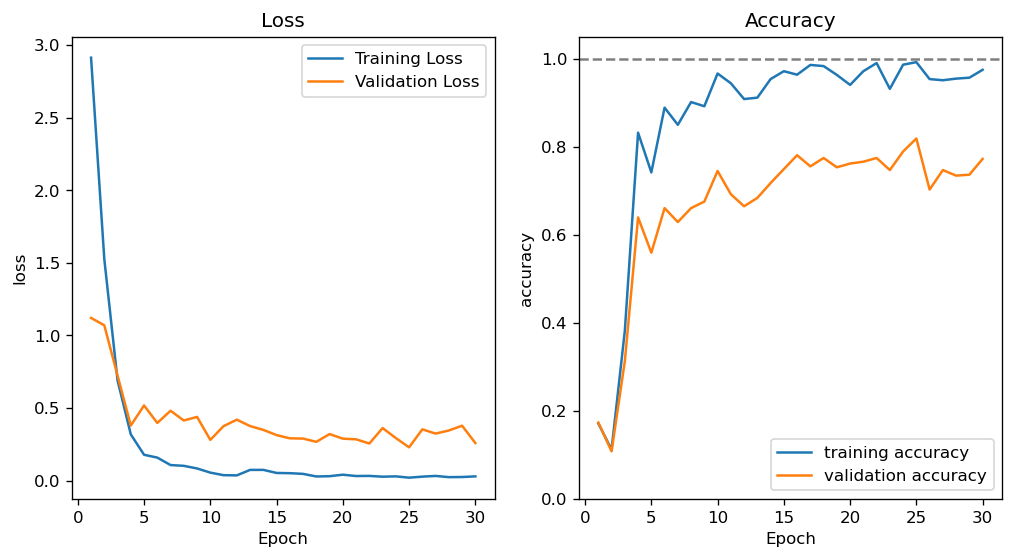

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=120)

ax1.plot(np.arange(n_epochs)+1,train_loss,label="Training Loss")
ax1.plot(np.arange(n_epochs)+1,val_loss,label="Validation Loss")
ax1.set_title("Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.axhline(y=1, color="black", linestyle="--", alpha=0.5)
ax2.plot(np.arange(n_epochs)+1,train_acc,label="training accuracy")
ax2.plot(np.arange(n_epochs)+1,val_acc,label="validation accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.set_ylim(0,1.05)
ax2.legend()

plt.savefig("images/ResNet.png")

In [11]:
torch.save(model.state_dict(),"models/ResNet/model.pth")